In [29]:
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
#from tqdm import tqdm  # For progress bar
from ABM_Final_Final_Final import SocialNetwork

In [30]:
# We define our variables and bounds
problem = {
    'num_vars': 3,
    'names': ['prob', 'social', 'n_agents'],
    'bounds': [[0., 1.], [0.,0.5], [50, 100]]
}

w_pop = 0.2
w_prox = 0.7
w_sim = 0.1

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 25
max_steps = 350
distinct_samples = 4

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples, calc_second_order=False)

# Initialize DataFrame to store results
num_samples = len(param_values) * replicates

data = pd.DataFrame(index=range(num_samples), columns=['prob', 'social', 'n_agents'])

data['Run'], data['max IN degree'], data['avg clustering coeff'] = None, None, None

print(data)
# https://stackoverflow.com/questions/67750857/how-to-activate-conda-environment-in-vs-code


   prob social n_agents   Run max IN degree avg clustering coeff
0   NaN    NaN      NaN  None          None                 None
1   NaN    NaN      NaN  None          None                 None
2   NaN    NaN      NaN  None          None                 None
3   NaN    NaN      NaN  None          None                 None
4   NaN    NaN      NaN  None          None                 None
5   NaN    NaN      NaN  None          None                 None
6   NaN    NaN      NaN  None          None                 None
7   NaN    NaN      NaN  None          None                 None
8   NaN    NaN      NaN  None          None                 None
9   NaN    NaN      NaN  None          None                 None
10  NaN    NaN      NaN  None          None                 None
11  NaN    NaN      NaN  None          None                 None
12  NaN    NaN      NaN  None          None                 None
13  NaN    NaN      NaN  None          None                 None
14  NaN    NaN      NaN  

C:\Users\franc\AppData\Local\Temp\ipykernel_16856\3177386572.py:18: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, distinct_samples, calc_second_order=False)


In [37]:
# Define your model
def run_model(count, params, max_steps):
    prob, social, n_agents = params
    print(n_agents)
    n_agents = int(n_agents)
    model = SocialNetwork(n_agents, prob, w_pop, w_prox, w_sim, social)
    for k in range(max_steps + 1):
        model.step()
        print(f"\rProgress: {(k / max_steps) * 100:.2f}%", end='', flush=True)
   
    df_results = pd.DataFrame(model.Data_Collector)
    
    return count, params,  df_results['avg clustering coeff'].iloc[-1], df_results['max IN degrees'].iloc[-1]

In [38]:
n_jobs = -1
count = 0

# Prepare a list to collect results
results = []

for i in range(replicates):
    with Parallel(n_jobs=n_jobs) as parallel:
        # Add progress bar
        parallel_results = parallel(
            delayed(run_model)(count + idx, vals, max_steps) 
            for idx, vals in enumerate(tqdm(param_values, desc=f"Replicate {i+1}/{replicates}"))
        )
    # Collect results
    results.extend(parallel_results)
    count += len(param_values)

# Save results to DataFrame

    #data.loc[run_id] = vals + [run_id, clustering_coeff, max_in]

# Save DataFrame to CSV
#data.to_csv(f"sobol_rep{replicates}_maxstep{max_steps}_distsamples{distinct_samples}.csv", index=False)


Replicate 2/2: 100%|██████████| 20/20 [00:00<?, ?it/s]


In [ ]:
for result in results:
    count = result[0]
    vals = list(result[1])
    clustering_coeff = result[2]
    max_in = result[3]
    data.at[count, "prob"] = vals[0]
    data.at[count, "social"] = vals[1]
    data.at[count, "n_agents"] = vals[2]
    data.iloc[count, len(vals):len(vals)+3] = count,max_in,clustering_coeff

print(data)

# Save DataFrame to CSV
data.to_csv(f"sobol_rep{replicates}_maxstep{max_steps}_distsamples{distinct_samples}.csv", index=False)

       prob    social Run max IN degree avg clustering coeff
0   0.09375  0.234375   0            34             0.239842
1   0.46875  0.234375   1            36              0.23878
2   0.09375  0.328125   2            30             0.248738
3   0.46875  0.328125   3            35             0.243546
4   0.59375  0.484375   4            38             0.264313
5   0.96875  0.484375   5            74             0.371415
6   0.59375  0.078125   6            47             0.273887
7   0.96875  0.078125   7            71             0.430481
8   0.84375  0.109375   8            60             0.366602
9   0.21875  0.109375   9            29             0.224795
10  0.84375  0.453125  10            61             0.334582
11  0.21875  0.453125  11            27             0.223864
12  0.34375  0.359375  12            29             0.230722
13  0.71875  0.359375  13            55             0.307988
14  0.34375  0.203125  14            26             0.227736
15  0.71875  0.203125  1

In [ ]:
Si_cluster = sobol.analyze(problem, data['avg clustering coeff'].values, calc_second_order=False, print_to_console=True)
Si_IN_Degree = sobol.analyze(problem, data['max IN degree'].values, calc_second_order=False, print_to_console=True)
#max(data['max IN degree'])

              ST   ST_conf
prob    0.955475  0.615395
social  0.021338  0.025412
              S1  S1_conf
prob    1.273724  0.42596
social  0.127137  0.08555
              ST   ST_conf
prob    1.365848  0.525771
social  0.034398  0.038086
              S1   S1_conf
prob    1.595086  0.785241
social  0.100737  0.259303


C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [ ]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

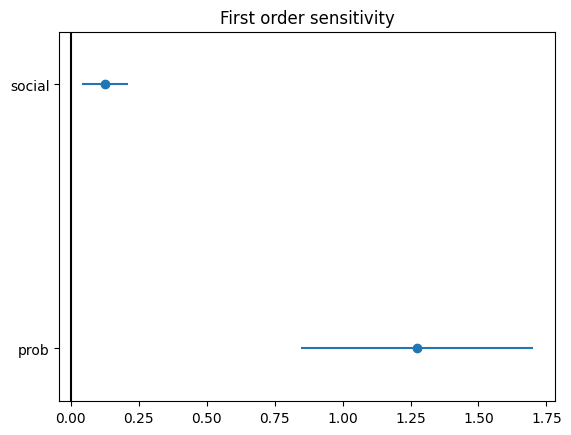

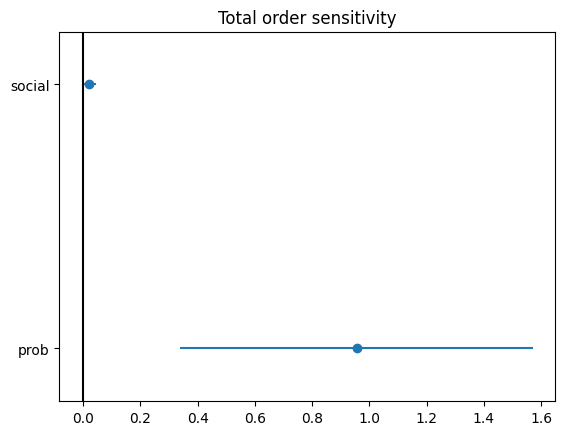

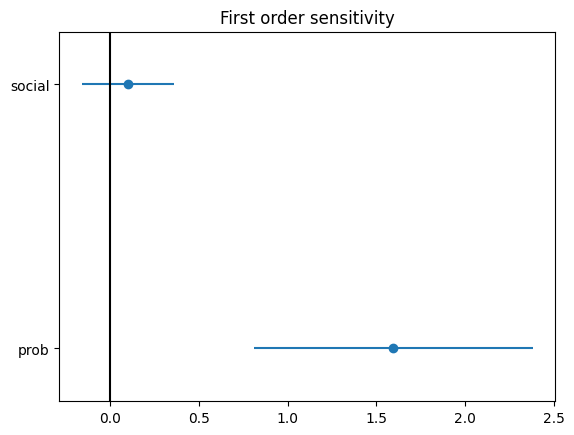

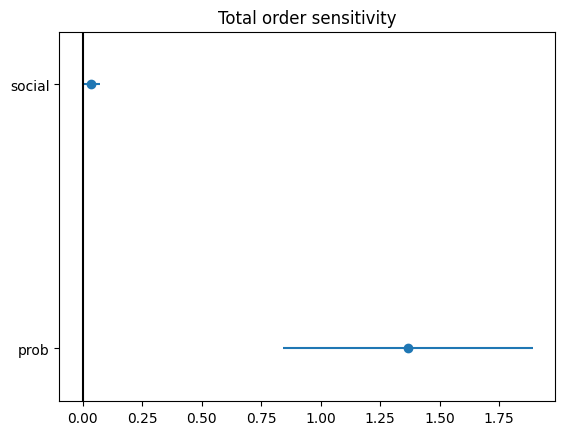

In [ ]:
for Si in (Si_cluster, Si_IN_Degree):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()